In [18]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

def plot_spectrogram(i):
    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')
    signal = (signal - np.mean(signal)) / (np.sqrt(np.var(signal)) + 1e-4)

    spects = librosa.amplitude_to_db(np.abs(librosa.stft(y=signal, n_fft=512, hop_length=128)))
    plt.figure(figsize=(10, 5))
    img = librosa.display.specshow(spects, y_axis='hz')
    plt.title('Spectrogram for a depressed participant')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time')
    plt.colorbar(img, format='%.2f')
    plt.show()

def plot_waveform_with_pauses(i, min_pause_length):
    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')
    signal = (signal - np.mean(signal)) / (np.sqrt(np.var(signal)) + 1e-4)


    plt.figure(figsize=(10, 5))
    librosa.display.waveshow(signal, alpha=0.7)

    pauses = librosa.effects.split(signal)

    time_per_sample = 1 / sr
    pause_times = np.array(pauses) * time_per_sample
    for pause_time in pause_times:
        pause_length = pause_time[1] - pause_time[0]
        if pause_length > min_pause_length:  # Check if pause length is greater than 250 ms
            plt.axvspan(pause_time[0], pause_time[1], color='red', alpha=0.3)


    # Plot pauses on waveform
    # time_per_sample = 1 / sr
    # pause_times = np.array(pauses) * time_per_sample
    # # print(pause_times)
    # for pause_time in pause_times:
    #     pause_length = pause_time[1] - pause_time[0]
    #     if pause_length > :  # Check if pause length is greater than min
    #         plt.axvspan(pause_time[0], pause_time[1], color='red', alpha=0.3)

    plt.title(f'Waveform with Pauses (Pause Length > {min_pause_length} s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def plot_pause_lengths_histogram(i):
    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')
    signal = (signal - np.mean(signal)) / (np.sqrt(np.var(signal)) + 1e-4)

    # Pause Lengths Histogram
    pauses = librosa.effects.split(signal)
    pause_lengths = [pause[1] - pause[0] for pause in pauses]
    plt.figure(figsize=(10, 5))
    plt.hist(pause_lengths, bins=50, color='skyblue', alpha=0.7)
    plt.title('Pause Lengths Histogram')
    plt.ylabel('Count')
    plt.xlabel('Pause Length')
    plt.grid(True)
    plt.show()

def plot_spectral_flux(i):
    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')
    signal = (signal - np.mean(signal)) / (np.sqrt(np.var(signal)) + 1e-4)

    plt.figure(figsize=(10, 5))
    spectral_flux = librosa.onset.onset_strength(y=signal)
    plt.plot(librosa.times_like(spectral_flux), spectral_flux, label='Spectral Flux', color='orange')
    plt.title('Spectral Flux for a depressed participant')
    plt.ylabel('Flux')
    plt.xlabel('Time (s)')
    plt.show()





In [4]:
interact(plot_spectrogram, i=(403, 493))


interactive(children=(IntSlider(value=448, description='i', max=493, min=403), Output()), _dom_classes=('widge…

<function __main__.plot_spectrogram(i)>

In [19]:
interact(plot_waveform_with_pauses, i=(403, 493), min_pause_length=(0, 10, 0.1))


interactive(children=(IntSlider(value=448, description='i', max=493, min=403), FloatSlider(value=5.0, descript…

<function __main__.plot_waveform_with_pauses(i, min_pause_length)>

In [ ]:
lightening studio



In [6]:
interact(plot_pause_lengths_histogram, i=(403, 493))


interactive(children=(IntSlider(value=448, description='i', max=493, min=403), Output()), _dom_classes=('widge…

<function __main__.plot_pause_lengths_histogram(i)>

In [7]:
interact(plot_spectral_flux, i=(403, 493))


interactive(children=(IntSlider(value=448, description='i', max=493, min=403), Output()), _dom_classes=('widge…

<function __main__.plot_spectral_flux(i)>

In [16]:
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import soundfile as sf
import speech_recognition as sr
from pydub import AudioSegment
import aubio
from pydub.silence import split_on_silence

def calculate_pitch_variation(i, audio_file_path):
    # Load audio file
    samples, samplerate = sf.read(audio_file_path, dtype='float32')

    # Initialize pitch object
    pitch_o = aubio.pitch("yin", samplerate=samplerate)
    
    # Array to store F0 values
    f0_values = []
    
    # Calculate F0 for each frame
    hop_size = 512
    total_frames = len(samples) // hop_size
    for i in range(total_frames):
        samples_frame = samples[i * hop_size:(i + 1) * hop_size]
        pitch = pitch_o(samples_frame)[0]
        if pitch != 0:
            f0_values.append(pitch)
    
    # Calculate average fundamental frequency
    average_f0 = np.mean(f0_values)
    
    # Calculate standard deviation of fundamental frequency
    std_dev_f0 = np.std(f0_values)
    
    # Calculate coefficient of variation (CV) of fundamental frequency
    cv_f0 = std_dev_f0 / average_f0
    
    return cv_f0

def calculate_speaking_rate(i, audio_file_path):
    # Initialize the recognizer
    recognizer = sr.Recognizer()

    # Load audio file
    with sr.AudioFile(audio_file_path) as source:
        audio_data = recognizer.record(source)

    # Transcribe speech
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        print("Could not understand audio")
        return
    except sr.RequestError as e:
        print("Error fetching results; {0}".format(e))
        return

    # Count the number of words
    words = text.split()
    word_count = len(words)

    # Get the duration of the audio
    audio_duration = len(audio_data.get_raw_data()) / (audio_data.sample_width * audio_data.sample_rate)

    # Calculate speaking rate (words per minute)
    speaking_rate = (word_count / audio_duration) * 60

    return speaking_rate

def calculate_percent_pause_time(i, audio_file_path):
    audio = AudioSegment.from_file(audio_file_path)
    silence_threshold = -50  # Adjust as needed
    min_silence_duration = 250  # in milliseconds
    silence_chunks = []

    # Detect silent parts
    silent_chunks = split_on_silence(
        audio,
        min_silence_len=min_silence_duration,
        silence_thresh=silence_threshold
    )

    # Filter silent parts longer than 250 ms
    silent_chunks_filtered = [chunk for chunk in silent_chunks if len(chunk) >= min_silence_duration]

    # Calculate total duration of remaining silent parts
    total_silent_duration = sum(len(chunk) for chunk in silent_chunks_filtered)

    # Calculate total duration of the audio
    total_duration = len(audio)

    # Calculate percent pause time score
    percent_pause_time_score = ((total_duration - total_silent_duration) / total_duration) * 100

    return percent_pause_time_score

# Create sliders for participant number (i)
slider_i_pitch = widgets.IntSlider(value=403, min=403, max=493, description='Participant Number:')
slider_i_speaking_rate = widgets.IntSlider(value=403, min=403, max=493, description='Participant Number:')
slider_i_pause_time = widgets.IntSlider(value=403, min=403, max=493, description='Participant Number:')

# Create interactive functions
@interact(i=slider_i_pitch)
def interactive_pitch_variation(i):
    audio_file_path = f'{i}_P/{i}_cleaned.wav'
    pitch_variation = calculate_pitch_variation(i, audio_file_path)
    print(f'Pitch Variation for participant {i}: {pitch_variation}')




interactive(children=(IntSlider(value=403, description='Participant Number:', max=493, min=403), Output()), _d…

In [14]:
@interact(i=slider_i_speaking_rate)
def interactive_speaking_rate(i):
    audio_file_path = f'{i}_P/{i}_cleaned.wav'
    speaking_rate = calculate_speaking_rate(i, audio_file_path)
    print(f'Speaking Rate (words per minute) for participant {i}: {speaking_rate}')



interactive(children=(IntSlider(value=403, description='Participant Number:', max=493, min=403), Output()), _d…

In [15]:


@interact(i=slider_i_pause_time)
def interactive_percent_pause_time(i):
    audio_file_path = f'{i}_P/{i}_cleaned.wav'
    percent_pause_time = calculate_percent_pause_time(i, audio_file_path)
    print(f'Percent Pause Time for participant {i}: {percent_pause_time}%')

interactive(children=(IntSlider(value=403, description='Participant Number:', max=493, min=403), Output()), _d…

In [17]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

def plot_zcr(i):
    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=2048, hop_length=512)
    
    plt.figure(figsize=(10, 5))
    plt.plot(librosa.times_like(zcr), zcr[0], label='ZCR', color='green')
    plt.title('Zero Crossing Rate (ZCR)')
    plt.xlabel('Time (s)')
    plt.ylabel('ZCR')
    plt.legend()
    plt.show()

def plot_mfcc(i):
    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('Mel-Frequency Cepstral Coefficients (MFCCs)')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC')
    plt.show()

def plot_chromagram(i):
    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=512)
    
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(chromagram, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch Class')
    plt.show()

def plot_formants(i):
    pass
    # Implement formant plot using appropriate libraries or methods
    
def plot_energy_envelope(i):
    pass
    # Implement energy envelope plot using appropriate libraries or methods
    
def plot_pitch_contour(i):
    pass
    # Implement pitch contour plot using appropriate libraries or methods
    
def plot_vad(i):
    pass
    # Implement voice activity detection plot using appropriate libraries or methods
    
def plot_hnr(i):
    pass
    # Implement harmonic-to-noise ratio plot using appropriate libraries or methods

# Create interactive functions
@interact(i=(403, 493))
def interactive_zcr(i):
    plot_zcr(i)

@interact(i=(403, 493))
def interactive_mfcc(i):
    plot_mfcc(i)

@interact(i=(403, 493))
def interactive_chromagram(i):
    plot_chromagram(i)

# Add interactions for other plots similarly


interactive(children=(IntSlider(value=448, description='i', max=493, min=403), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=448, description='i', max=493, min=403), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=448, description='i', max=493, min=403), Output()), _dom_classes=('widge…

In [35]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

def plot_with_widgets(i=403, min_pause_length=2):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

    signal, sr = librosa.load(f'{i}_P/{i}_cleaned.wav')

    spects = librosa.amplitude_to_db(np.abs(librosa.stft(y=signal, n_fft=512, hop_length=128)))
    img = librosa.display.specshow(spects, y_axis='hz', ax=axes[0])
    axes[0].set_title('Spectrogram for a depressed participant')
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    plt.colorbar(img, ax=axes[0], format='%.2f')

    # Plot the waveform
    axes[1].clear()
    librosa.display.waveshow(signal, alpha=0.7, ax=axes[1])

    # Plot pauses on waveform
    pauses = librosa.effects.split(signal)
    time_per_sample = 1 / sr
    pause_times = np.array(pauses) * time_per_sample
    for pause_time in pause_times:
        pause_length = pause_time[1] - pause_time[0]
        if pause_length > min_pause_length:  # Check if pause length is greater than min
            plt.axvspan(pause_time[0], pause_time[1], color='red', alpha=0.3)


    # pause_lengths = [pause[1] - pause[0] for pause in pause_times]
    # for pause in pauses:
    #     pause_length = (pause[1] - pause[0]) / sr
    #     if pause_length > min_pause_length:
    #         plt.axvspan(pause_time[0], pause_time[1], color='red', alpha=0.3)


    axes[1].set_title(f'Waveform with Pauses (Pause Length > {min_pause_length} s)')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude')

    # Pause Lengths Histogram
    axes[2].clear()
    axes[2].hist(pause_lengths, bins=50, color='skyblue', alpha=0.7)
    axes[2].set_title('Pause Lengths Histogram')
    axes[2].set_ylabel('Count')
    axes[2].set_xlabel('Pause Length')
    axes[2].grid(True)

    # Spectral Flux
    axes[3].clear()
    spectral_flux = librosa.onset.onset_strength(y=signal)
    axes[3].plot(librosa.times_like(spectral_flux), spectral_flux, label='Spectral Flux', color='orange')
    axes[3].set_title('Spectral Flux for a depressed participant')
    axes[3].set_ylabel('Flux')
    axes[3].set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

interact(plot_with_widgets, i=(403, 493), min_pause_length=(0, 10, 0.1))


interactive(children=(IntSlider(value=403, description='i', max=493, min=403), FloatSlider(value=2.0, descript…

<function __main__.plot_with_widgets(i=403, min_pause_length=2)>

/tmp/ipykernel_2077167/2664504832.py:7: WavFileWarning: Reached EOF prematurely; finished at 27600044 bytes, expected 220800044 bytes from header.
  sample_rate, data = wavfile.read('/home/agarwal.aditi/mental_health/403_P/403_AUDIO.wav')


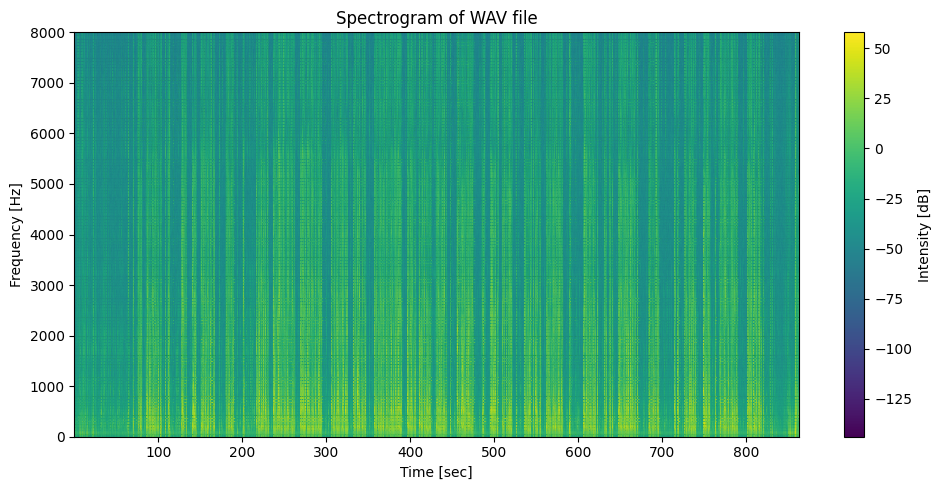

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

# Load the WAV file
sample_rate, data = wavfile.read('/home/agarwal.aditi/mental_health/403_P/403_AUDIO.wav')

# Compute the spectrogram
frequencies, times, spectrogram_data = spectrogram(data, fs=sample_rate)

# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram_data), shading='gouraud')  # Convert to dB scale
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of WAV file')
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()
plt.show()


/tmp/ipykernel_2077167/1380251273.py:9: WavFileWarning: Reached EOF prematurely; finished at 27600044 bytes, expected 220800044 bytes from header.
  sample_rate, data = wavfile.read('/home/agarwal.aditi/mental_health/403_P/403_AUDIO.wav')


ValueError: x and y must have same first dimension, but have shapes (61607,) and (225,)

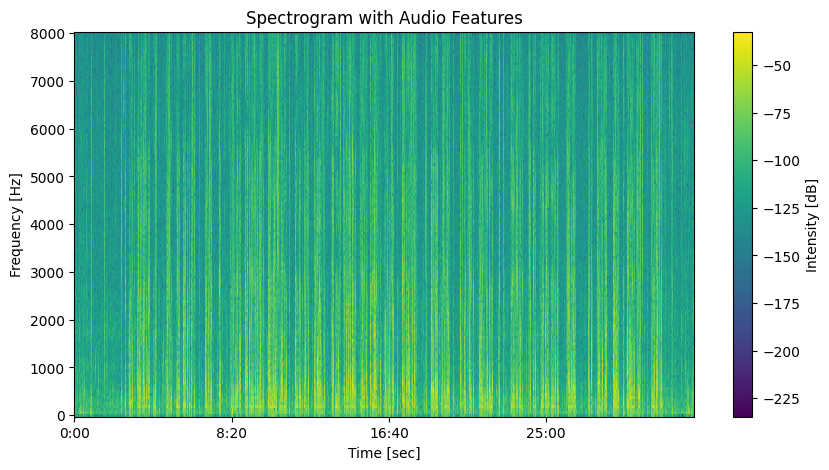

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import librosa
import librosa.display

# Load the WAV file
sample_rate, data = wavfile.read('/home/agarwal.aditi/mental_health/403_P/403_AUDIO.wav')

# Convert audio data to floating point
data_float = data.astype(np.float32) / np.max(np.abs(data))

# Compute the spectrogram
frequencies, times, spectrogram_data = spectrogram(data_float, fs=sample_rate)

# Compute audio features with the same length as times
zero_crossings = librosa.feature.zero_crossing_rate(y=data_float, frame_length=len(times)).flatten()
centroid = librosa.feature.spectral_centroid(y=data_float, sr=sample_rate, hop_length=len(times)).flatten()
bandwidth = librosa.feature.spectral_bandwidth(y=data_float, sr=sample_rate, hop_length=len(times)).flatten()

# Plot the spectrogram
plt.figure(figsize=(10, 5))
librosa.display.specshow(10 * np.log10(spectrogram_data), sr=sample_rate, x_axis='time', y_axis='linear', cmap='viridis')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram with Audio Features')
plt.colorbar(label='Intensity [dB]')

# Overlay features
# plt.plot(times, zero_crossings / np.max(zero_crossings) * frequencies.max(), color='red', label='Zero Crossing Rate')
plt.plot(times, centroid, color='blue', label='Spectral Centroid')
plt.plot(times, bandwidth, color='green', label='Spectral Bandwidth')

plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_2077167/1377421871.py:9: WavFileWarning: Reached EOF prematurely; finished at 27600044 bytes, expected 220800044 bytes from header.
  sample_rate, data = wavfile.read('/home/agarwal.aditi/mental_health/403_P/403_AUDIO.wav')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


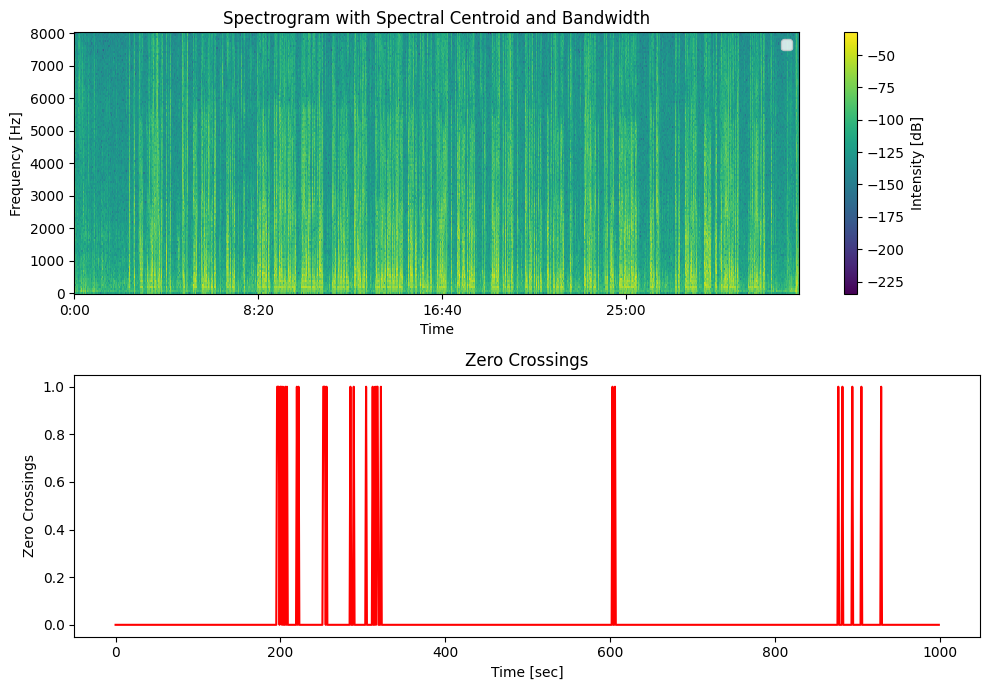

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import librosa
import librosa.display

# Load the WAV file
sample_rate, data = wavfile.read('/home/agarwal.aditi/mental_health/403_P/403_AUDIO.wav')

# Convert audio data to floating point
data_float = data.astype(np.float32) / np.max(np.abs(data))

# Compute the spectrogram
frequencies, times, spectrogram_data = spectrogram(data_float, fs=sample_rate)

# Compute audio features with the same length as times
centroid = librosa.feature.spectral_centroid(y=data_float, sr=sample_rate, hop_length=len(times)).flatten()
bandwidth = librosa.feature.spectral_bandwidth(y=data_float, sr=sample_rate, hop_length=len(times)).flatten()

# Compute zero crossings
zero_crossings = librosa.zero_crossings(data_float, pad=False)

# Plot the spectrogram and other features
plt.figure(figsize=(10, 7))

# Plot the spectrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(10 * np.log10(spectrogram_data), sr=sample_rate, x_axis='time', y_axis='linear', cmap='viridis')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram with Spectral Centroid and Bandwidth')
plt.colorbar(label='Intensity [dB]')

# Overlay spectral centroid and bandwidth
# plt.plot(times, centroid, color='blue', label='Spectral Centroid')
# plt.plot(times, bandwidth, color='green', label='Spectral Bandwidth')
plt.legend()

zero_crossings = zero_crossings.astype(int)

# Plot zero crossings
plt.subplot(2, 1, 2)
plt.plot(zero_crossings[:1000], color='red', label='Zero Crossings')
plt.xlabel('Time [sec]')
plt.ylabel('Zero Crossings')
plt.title('Zero Crossings')
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
pd.Series(zero_crossings).value_counts()

0    12758388
1     1041612
Name: count, dtype: int64

In [19]:
len(zero_crossings)

13800000

In [23]:
zero_crossings

array([0, 0, 0, ..., 0, 0, 0])

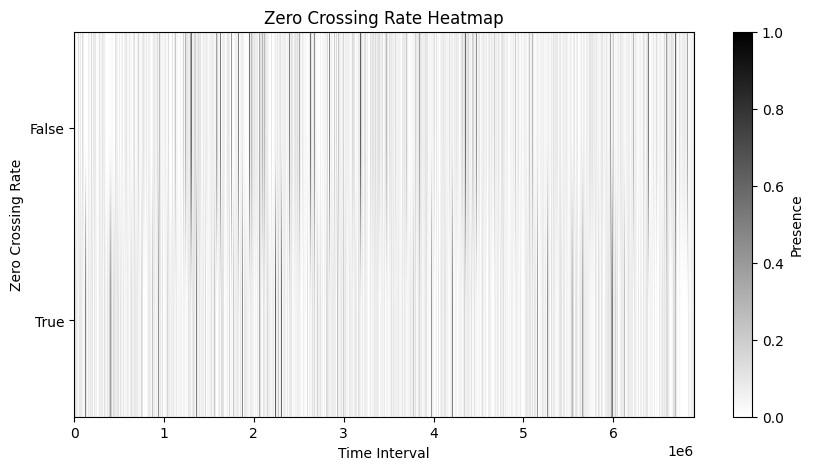

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your zero crossing rate array is called zcr_array
# zcr_array = [False] * 12758388 + [True] * 1041612

# Reshape the zero crossing rate array into a 2D array for heatmap
zcr_heatmap = np.array(zero_crossings).reshape(2, -1)

# Plot the heatmap
plt.figure(figsize=(10, 5))
plt.imshow(zcr_heatmap, cmap='binary', aspect='auto')
plt.xlabel('Time Interval')
plt.ylabel('Zero Crossing Rate')
plt.title('Zero Crossing Rate Heatmap')
plt.yticks([0, 1], ['False', 'True'])  # Set y-axis labels
plt.colorbar(label='Presence')
plt.show()
